In [1]:
14%%6

[1] 2

In [2]:
#####################Q1
install.packages(c("forecast", "tseries"), repos="https://cloud.r-project.org")

Installing packages into 'C:/Users/Sakib/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)



package 'forecast' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'forecast'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\Sakib\AppData\Local\R\win-library\4.5\00LOCK\forecast\libs\x64\forecast.dll to C:\Users\Sakib\AppData\Local\R\win-library\4.5\forecast\libs\x64\forecast.dll: Permission denied"
Warning message:
"restored 'forecast'"


package 'tseries' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'tseries'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\Sakib\AppData\Local\R\win-library\4.5\00LOCK\tseries\libs\x64\tseries.dll to C:\Users\Sakib\AppData\Local\R\win-library\4.5\tseries\libs\x64\tseries.dll: Permission denied"
Warning message:
"restored 'tseries'"



The downloaded binary packages are in
	C:\Users\Sakib\AppData\Local\Temp\RtmpErvYsI\downloaded_packages


In [3]:
#Load libraries
library(forecast)
library(tseries)

Warning message:
"package 'forecast' was built under R version 4.5.1"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Warning message:
"package 'tseries' was built under R version 4.5.1"


In [4]:
#Load the data
data(austres)

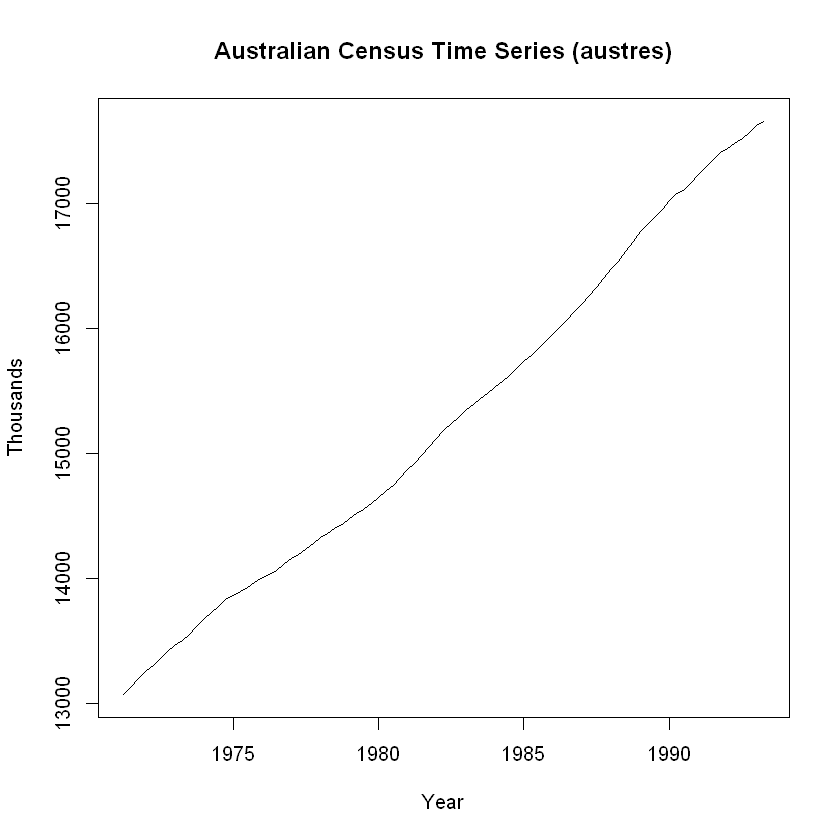

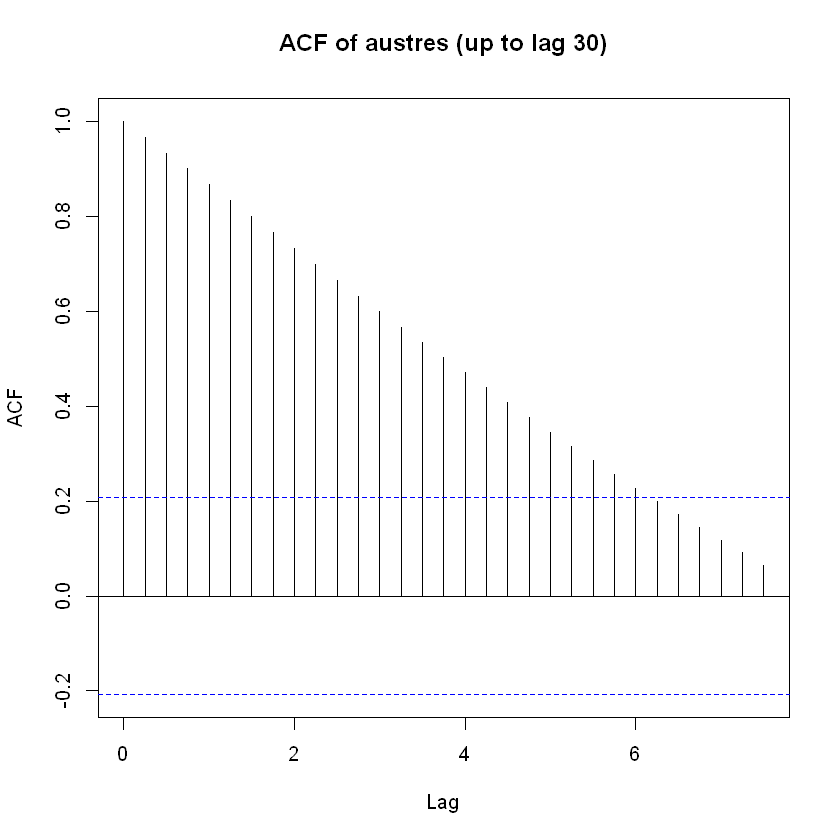

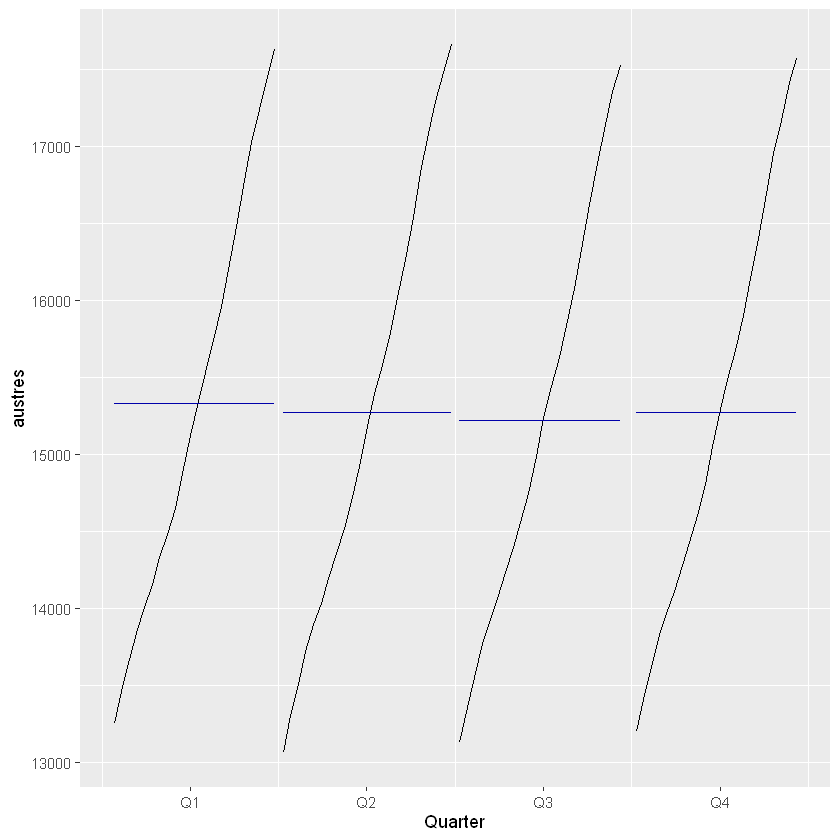

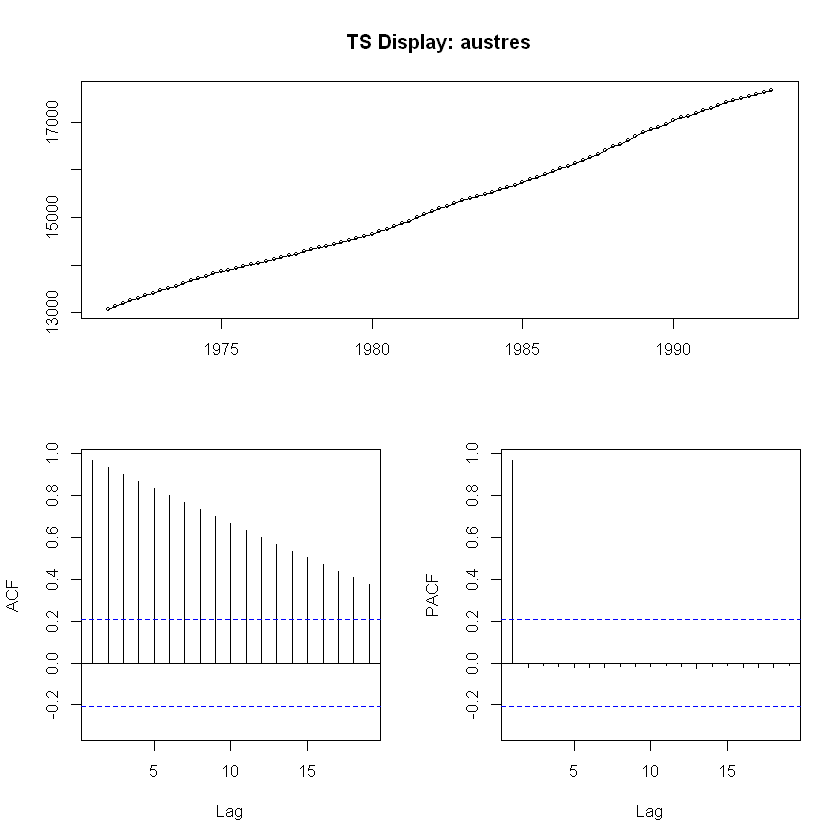

In [7]:
#Exploratory plots
plot(austres, main="Australian Census Time Series (austres)", ylab="Thousands", xlab="Year")
acf(austres, lag.max=30, main="ACF of austres (up to lag 30)")
ggsubseriesplot(austres)          # seasonal subseries plot
tsdisplay(austres, main="TS Display: austres")  # series, ACF, PACF


In [8]:
#Compute lengths and 70% cutoff
n <- length(austres)
n            # total obs (89)
train_end<- floor(0.7 * n)             # floor(89 * 0.7) = 62


[1] 89

In [9]:
# year:
yr  <- floor(time(austres)[train_end + 1])
# quarter:
qtr <- cycle(austres)[train_end + 1]
c(yr, qtr)


[1] 1986    4

In [ ]:
traindata=ts(austres[1:62], frequency = 4, start=c(1971,2))
testdata=ts(austres[63:n], frequency = 4, start = c(1986,4))

length(traindata)    
length(testdata)     

[1] 62

[1] 27

In [11]:
#### Q2: Stationarity testing and differencing for quarterly series ####
library(tseries)
#Original series tests
adf.orig  <- adf.test(traindata)
kpss.orig <- kpss.test(traindata)

Warning message in kpss.test(traindata):
"p-value smaller than printed p-value"


In [12]:
adf.test(traindata)$p.value
kpss.test(traindata)$p.value


[1] 0.852613

Warning message in kpss.test(traindata):
"p-value smaller than printed p-value"


[1] 0.01

ADF p>0.05 → H0 is failed to reject, non-stationary
KPSS p<0.05 → H0 is rejected, stationarity

[1] 0.2706402

[1] 0.08767568

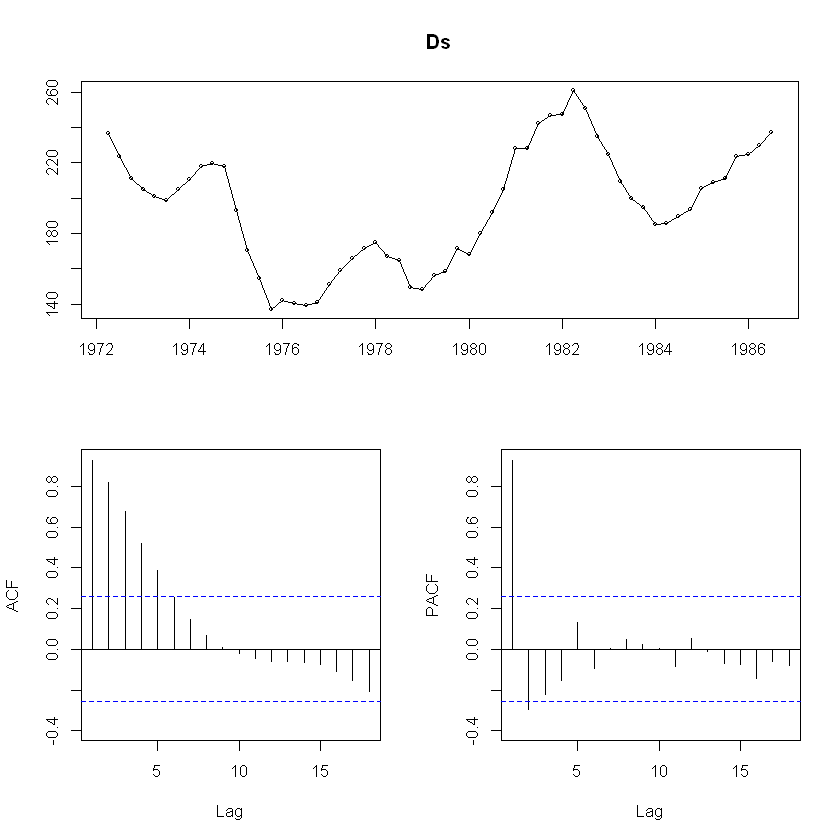

In [ ]:
# Try a seasonal difference (D = 1 @ lag = 4)
Ds <- diff(traindata, lag = frequency(traindata), differences = 1)
tsdisplay(Ds)
adf.Ds  <- adf.test(Ds)
kpss.Ds <- kpss.test(Ds)
adf.Ds$p.value
kpss.Ds$p.value


#⇒ ADF p-value: 0.2706 | KPSS p-value: 0.0877 

Warning message in adf.test(d1Ds):
"p-value smaller than printed p-value"
Warning message in kpss.test(d1Ds):
"p-value greater than printed p-value"


[1] 0.01

[1] 0.1

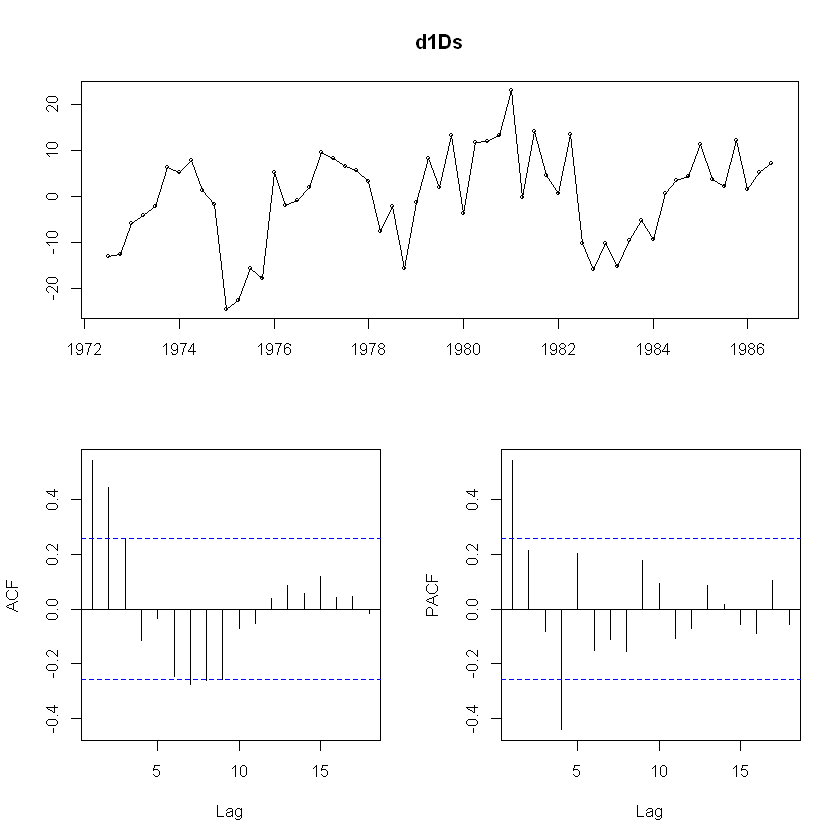

In [14]:
#Combined non-seasonal & seasonal: d=1, D=1
d1Ds <- diff(Ds, differences = 1)
tsdisplay(d1Ds)
adf.d1Ds  <- adf.test(d1Ds)
kpss.d1Ds <- kpss.test(d1Ds)
adf.d1Ds$p.value
kpss.d1Ds$p.value


# ⇒ ADF p-value: < 0.05 AND KPSS p-value: > 0.05 ⇒ Series is now stationary
#p=1 from the PACF cut‐off at lag 1, d=1 because one non-seasonal difference and q=4 from the ACF cut‐off at lag 4



	Ljung-Box test

data:  Residuals from ARIMA(1,1,4)
Q* = 12.154, df = 3, p-value = 0.006875

Model df: 5.   Total lags used: 8



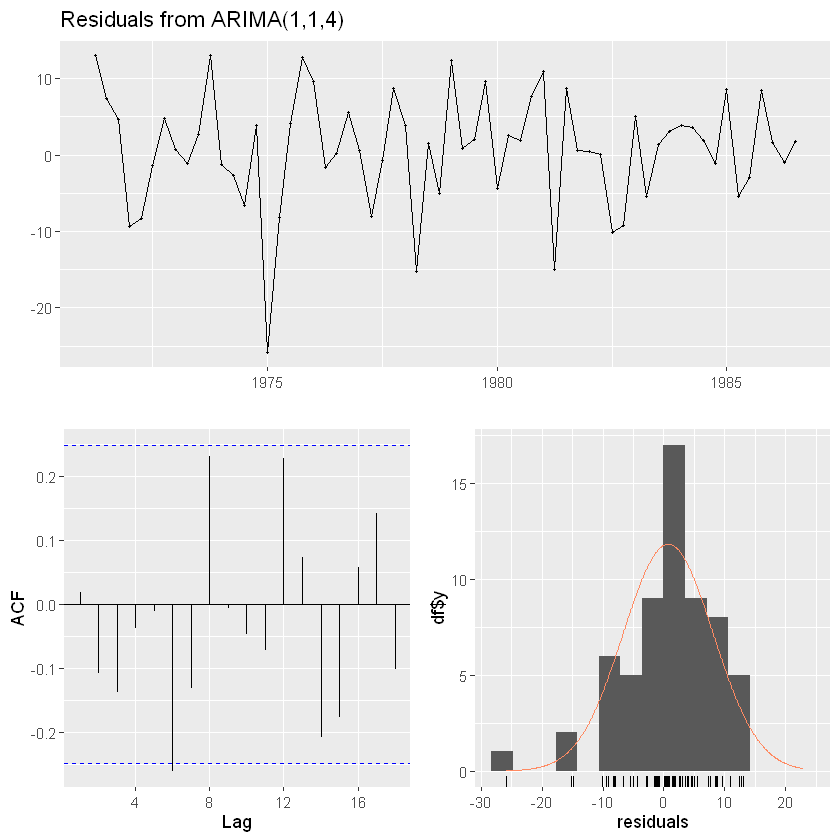

In [15]:
M1 <- Arima(traindata, order=c(1,1,4))
# 1) Look at the residual plots + ACF
library(forecast)
checkresiduals(M1)

#all key checks pass—your M1 model’s residuals behave like white noise and are approximately Gaussian. Confidently proceed with M1 as my chosen ARIMA(1,1,4).

In [19]:
#Capture the summary of M1
sm1 <- summary(M1)

# 2) Extract AICc and BIC
sm1$aicc   # 433.65
sm1$bic    # 444.76

[1] 433.6484

[1] 444.7581

#ARIMA(1,1,4) captures the dynamics well (strong AR(1), notable MA(1) & MA(4)), yields low forecasting errors (MAPE < 4%), and balances fit versus complexity with AICc ≈ 434.

#### Q3: Transform + ARIMA (M2) ####

In [20]:
#Log‐transform
y <- log(traindata)

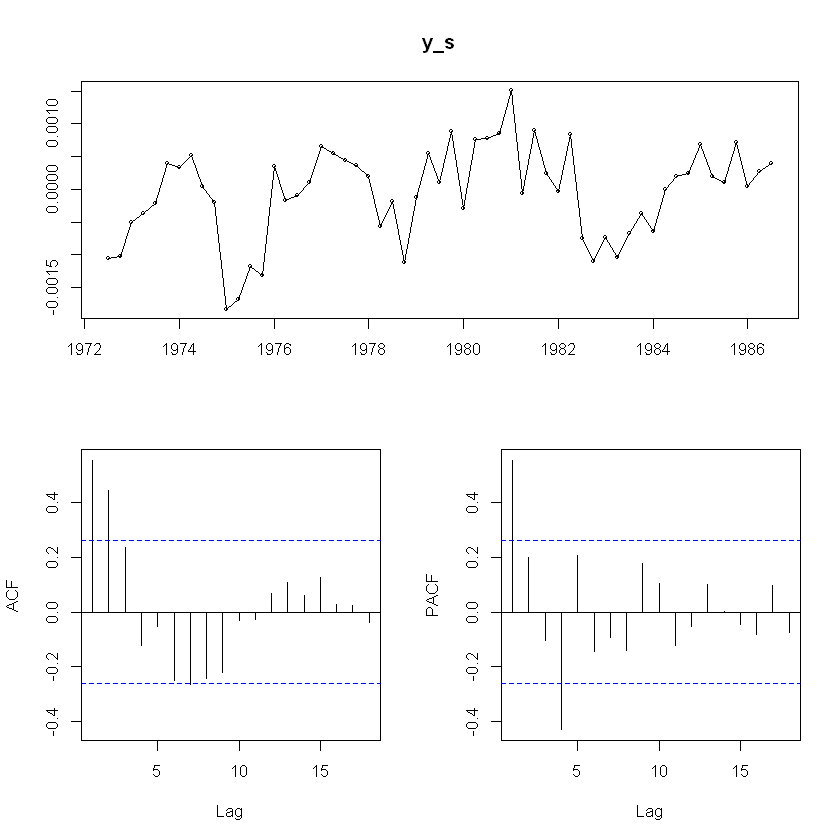

In [21]:
#Stationarize: non‐seasonal diff (d=1) + seasonal diff (D=1 at lag=4)
y_s <- diff(diff(y, lag=4), differences = 1)

#Inspect ACF & PACF of the stationary series
tsdisplay(y_s)

#    – p=0 (PACF tails off)
#    – q=1 (ACF cuts off at lag 1)
#    – P=0, Q=1 (seasonal ACF spike at lag 4)
#    – d=1, D=1 already applied

In [22]:
#Fit M2
M2 <- Arima(
  y,
  order    = c(0,1,1),
  seasonal = list(order = c(0,1,1), period = 4)
)

summary(M2)

Series: y 
ARIMA(0,1,1)(0,1,1)[4] 

Coefficients:
         ma1     sma1
      0.4908  -0.4131
s.e.  0.1040   0.1606

sigma^2 = 8.499e-06:  log likelihood = 342.89
AIC=-679.78   AICc=-679.33   BIC=-673.65

Training set error measures:
                        ME        RMSE          MAE          MPE       MAPE
Training set -0.0002755167 0.002745739 0.0009359047 -0.002901007 0.00981811
                  MASE      ACF1
Training set 0.0697547 0.1696524

#Model fit: M2 = ARIMA(0,1,1)(0,1,1)[4] on log-data has non‐seasonal MA(1)=0.4908 and seasonal MA(1)=−0.4131, with AICc=−679.33 and very low training RMSE (0.00275), indicating an excellent in-sample fit.


	Ljung-Box test

data:  Residuals from ARIMA(0,1,1)(0,1,1)[4]
Q* = 7.1807, df = 6, p-value = 0.3045

Model df: 2.   Total lags used: 8



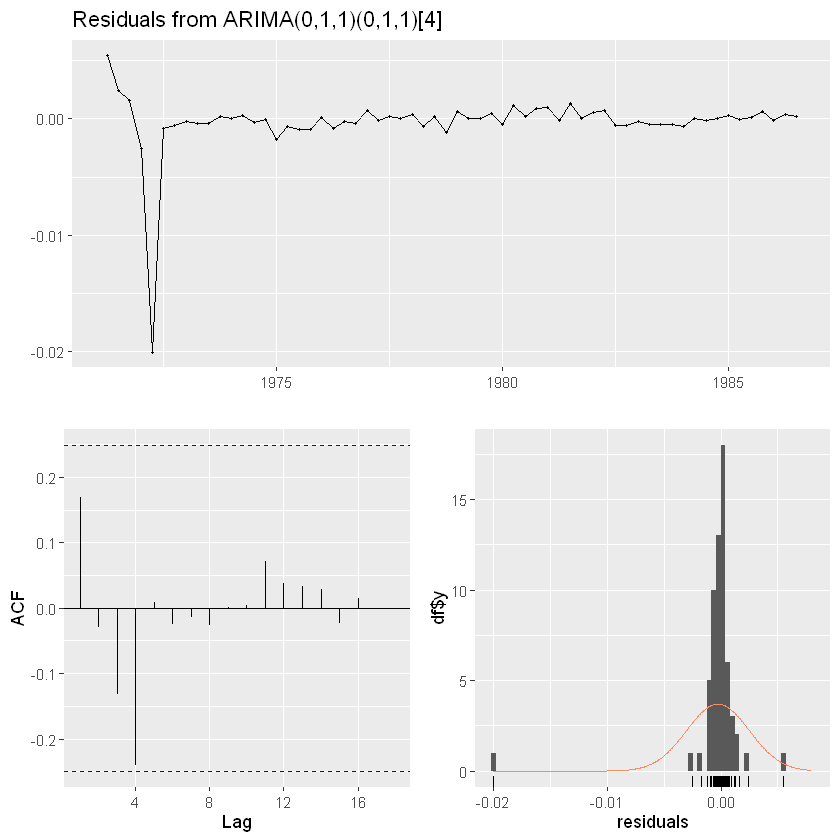

In [23]:
#Residual check
checkresiduals(M2)

# check: Ljung–Box Q(6)=7.18, p=0.3045 (>0.05) ⇒ fail to reject no autocorrelation ⇒ residuals behave like white noise.


#### Q4: Box–Cox transform + ARIMA (M3) ####

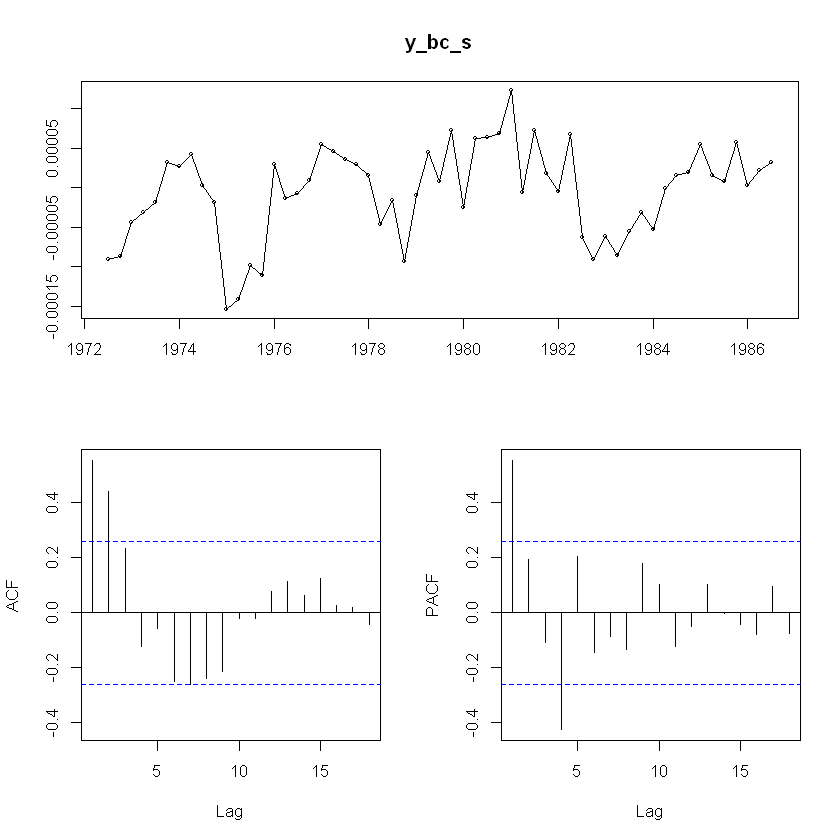

In [24]:
#Find optimal λ and transform
lambda <- BoxCox.lambda(traindata)
y_bc   <- BoxCox(traindata, lambda)     

#Difference to stationarity (d=1, D=1 @ lag=4)
y_bc_s <- diff(diff(y_bc, lag=4), differences = 1)


# Inspect ACF & PACF of the stationary series
tsdisplay(y_bc_s)

#M3 = ARIMA(0,1,3)(1,1,0)[4] 

Series: y_bc 
ARIMA(0,1,3)(1,1,0)[4] 
Box Cox transformation: lambda= -0.2606806 

Coefficients:
         ma1     ma2     ma3     sar1
      0.6300  0.7723  0.4818  -0.1658
s.e.  0.1614  0.1440  0.1673   0.1386

sigma^2 = 1.083e-07:  log likelihood = 586.72
AIC=-1163.43   AICc=-1162.26   BIC=-1153.22

Training set error measures:
                        ME        RMSE         MAE          MPE        MAPE
Training set -0.0001185785 0.001485673 0.000313484 -0.003374315 0.008921804
                  MASE      ACF1
Training set 0.2840209 0.1357004


	Ljung-Box test

data:  Residuals from ARIMA(0,1,3)(1,1,0)[4]
Q* = 7.583, df = 4, p-value = 0.1081

Model df: 4.   Total lags used: 8



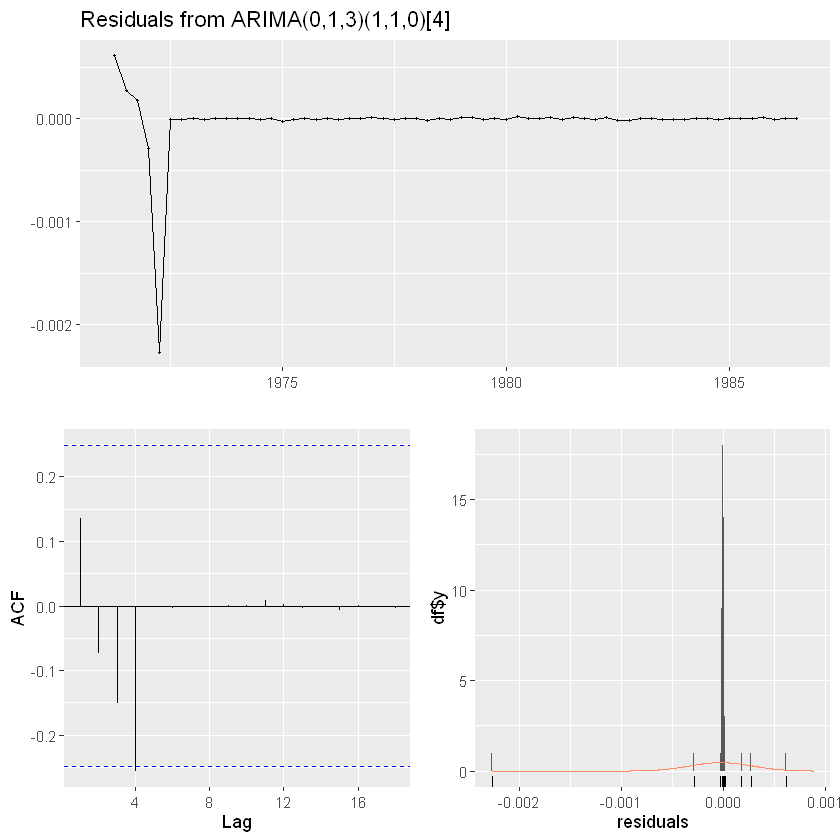

In [25]:
# Fit M3
M3 <- Arima(
  y_bc,
  order    = c(0,1,3),
  seasonal = list(order = c(1,1,0), period = 4),
  lambda   = lambda
)

summary(M3)
checkresiduals(M3)

#The three non-seasonal MA coefficients (0.630, 0.772, 0.482) plus seasonal AR₁ (−0.166) are all significant, yielding σ²≈1.08e-⁷, AICc≈−1162.26

#In-sample errors are tiny (RMSE≈0.00149, MAPE≈0.89%), so M3 provides an excellent fit

#The Ljung–Box test on M3’s residuals gives Q* = 7.58 with p = 0.1081 (> 0.05) ⇒ fail to reject “no autocorrelation,” so the residuals behave like white noise and M3 is an adequate fit.


#### Q5: Auto‐ARIMA (M4) + model comparison ####

In [26]:
#Fit M4 automatically
M4 <- auto.arima(traindata,
                 lambda   = BoxCox.lambda(traindata),
                 seasonal = TRUE)


In [27]:
# Gather AIC, AICc & BIC for M1–M4
metrics <- data.frame(
  Model = c("M1","M2","M3","M4"),
  AIC   = c(AIC(M1),   AIC(M2),   AIC(M3),   AIC(M4)),
  AICc  = c(summary(M1)$aicc,
            summary(M2)$aicc,
            summary(M3)$aicc,
            summary(M4)$aicc),
  BIC   = c(BIC(M1),   BIC(M2),   BIC(M3),   BIC(M4))
)
print(metrics)


  Model        AIC       AICc        BIC
1    M1   432.0928   433.6484   444.7581
2    M2  -679.7800  -679.3271  -673.6508
3    M3 -1163.4325 -1162.2561 -1153.2173
4    M4 -1054.1023 -1052.5467 -1041.4371


In [28]:
#select best by AICc
best_by_AICc <- metrics$Model[which.min(metrics$AICc)]
cat("Best model by AICc is", best_by_AICc, "\n\n")

Best model by AICc is M3 



In [29]:
#Quick residual‐diagnostic p-values for each model
diag_p <- sapply(list(M1=M1, M2=M2, M3=M3, M4=M4), function(mod){
  c(
    Ljung_Box   = Box.test(residuals(mod), lag=10, type="Ljung-Box")$p.value,
    Shapiro_Wilk = shapiro.test(residuals(mod))$p.value
  )
})
round(diag_p, 3)

,M1,M2,M3,M4
Ljung_Box,0.264,0.708,0.669,1
Shapiro_Wilk,0.015,0.000,0.000,0


#                M1     M2     M3    M4
#Ljung_Box    0.264  0.708  0.669   1.000   # these are the Ljung–Box p-values
#Shapiro_Wilk 0.015  0.000  0.000   0.000   # these are the Shapiro–Wilk p-values
#All four models pass the Ljung–Box test (p > 0.05), so their residuals show no remaining autocorrelation, but none pass the Shapiro–Wilk test (all p < 0.05), indicating that residuals from every model significantly deviate from normality.

